## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    OrdinalEncoder,
    MinMaxScaler,
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LogisticRegression ,LinearRegression, Ridge, RidgeCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    VotingClassifier,
    StackingClassifier,
)

from sklearn.model_selection import GridSearchCV

# from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier
from xgboost import XGBClassifier

## Files

The Kaggle Spaceship Titanic competition is all about predicting which passengers will be transported to another dimension or not. The target is a binary response of either True or False.

In [2]:
df = pd.read_csv("train.csv")
test_df_kaggle = pd.read_csv("test.csv")

## Data Splitting

First I needed to split up the X and Y from the training data. It is important to know that the files imported are already split into a training set and testing set.

In [3]:
X_train = df.drop(columns="Transported")
y_train = df["Transported"]

## EDA

I started by looking at training data set and how the data was set up.

In [4]:
X_train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
dtypes: float64(6), object(7)
memory usage: 883.0+ KB


Upon analysis it was clear that there was a mix of data types including ints and strings.

In [6]:
X_train["Destination"].loc[:].value_counts()

TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64

In [7]:
X_train["Cabin"].loc[:].value_counts()

G/734/S     8
G/109/P     7
B/201/P     7
G/1368/P    7
G/981/S     7
           ..
G/556/P     1
E/231/S     1
G/545/S     1
G/543/S     1
F/947/P     1
Name: Cabin, Length: 6560, dtype: int64

## Feature Engineering

The main feature I noticed in the EDA that need extra engineering was the feature "Cabin". It was a combination of 3 features that could be split. This would make it more useful.

In [8]:
X_train[["Deck", "Cabin_num", "Side"]] = X_train["Cabin"].str.split(
    "/", expand=True
)
X_train = X_train.drop('Cabin', axis=1)
X_train.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Deck,Cabin_num,Side
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,B,0,P
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,F,0,S
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,A,0,S
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,A,0,S
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,F,1,S


In [9]:
submission_id = test_df_kaggle["PassengerId"]
test_df_kaggle[["Deck", "Cabin_num", "Side"]] = test_df_kaggle["Cabin"].str.split(
    "/", expand=True
)
test_df_kaggle.drop('Cabin', axis=1, inplace=True)

## PreProcessing

These were the different features and transformations I decided to apply.

|     | Feature      | Transformation           | Missing Data                   | Type                         |
| --- | ------------ | ------------------------ | ------------------------------ | ---------------------------- |
| 1   | PassengerId  | DROP                     | -                              | -                            |
| 2   | HomePlanet   | OneHot Encoder           | Simple Imputer (most_frequent) | categorical_features         |
| 3   | CryoSleep    | OneHot Encoding (BINARY) | Simple Imputer (most_frequent) |                              |
| 4   | Destination  | OneHot Encoding          | Simple Imputer (most_frequent) | categorical_features         |
| 5   | Age          | Min-Max                  | Simple Imputer (median)        | numeric_features_min_max     |
| 6   | VIP          | OneHot Encoding (BINARY) | Simple Imputer (most_frequent) | binary_features              |
| 7   | RoomService  | Standardize              | Simple Imputer (median)        | numeric_features_standardize |
| 8   | FoodCourt    | Standardize              | Simple Imputer (median)        | numeric_features_standardize |
| 9   | ShoppingMall | Standardize              | Simple Imputer (median)        | numeric_features_standardize |
| 10  | Spa          | Standardize              | Simple Imputer (median)        | numeric_features_standardize |
| 11  | VRDeck       | Standardize              | Simple Imputer (median)        | numeric_features_standardize |
| 12  | Name         | DROP                     | -                              | -                            |
| 13  | Deck         | One-Hot Encoder          | Simple Imputer (most_frequent) | categorical_features         |
| 14  | Cabin_num    | DROP                     | -                              | -                            |
| 15  | Side         | One-Hot Encoder          | Simple Imputer (most_frequent) | categorical_features         |


In [10]:
numeric_features_min_max = ["Age"]
numeric_features_standardize = [
    "RoomService",
    "FoodCourt",
    "ShoppingMall",
    "Spa",
    "VRDeck",
]
categorical_features = ["HomePlanet", "Destination", "Deck", "Side"]
binary_features = ["CryoSleep", "VIP"]
drop_features = ["PassengerId", "Name", "Cabin_num"]
target = "Transported"

Here is my preprocessing column transformer pipeline created using the information created above.

In [11]:
ct = make_column_transformer(
    (
        make_pipeline(SimpleImputer(strategy="median"), MinMaxScaler()),
        numeric_features_min_max,
    ),
    (
        make_pipeline(SimpleImputer(strategy="median"), StandardScaler()),
        numeric_features_standardize,
    ),
    (
        make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(sparse=False)),
        categorical_features,
    ),
    (
        make_pipeline(
            SimpleImputer(strategy="most_frequent"), OneHotEncoder(drop="if_binary", sparse=False)
        ),
        binary_features,
    ),
    ("drop", drop_features),
)

In [12]:
ct.fit(X_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['Age']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['RoomService', 'FoodCourt', 'ShoppingMall',
                                  'Spa', 'VRDeck']),
                                ('pipeline-3',
                                 Pi...
                                                  SimpleImputer(stra

In [13]:
transformed = ct.fit_transform(X_train)

## Model Building

Set a way to store model results to more easily compare them against each other.

In [14]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [15]:
label_encoder = LabelEncoder()
y_train_num = label_encoder.fit_transform(y_train)

In [16]:
results = {}
scoring_metric = "accuracy"

## Dummy Model

The first model is a baseline dummy model. The model predicts the most frequent value as the outcome for all.

In [17]:
dummy = DummyClassifier()
pd.DataFrame(cross_validate(dummy, transformed, y_train_num, return_train_score=True))


,fit_time,score_time,test_score,train_score
0,0.002037,0.000378,0.503738,0.503595
1,0.000667,0.000391,0.503738,0.503595
2,0.000961,0.000815,0.503738,0.503595
3,0.001726,0.000448,0.503452,0.503666
4,0.001036,0.000419,0.503452,0.503666


## Model 1: Decision Tree

I started with a decision tree model because that would work well with the features in the dataset.

In [18]:
pipe_dt = make_pipeline(ct, DecisionTreeClassifier(random_state=123))
pipe_dt.fit(X_train, y_train_num)
results["Decision tree"] = mean_std_cross_val_scores(
    pipe_dt, X_train, y_train_num, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Decision tree,0.065 (+/- 0.016),0.012 (+/- 0.003),0.737 (+/- 0.009),0.949 (+/- 0.003)


I tried a few hyperparameters to fine tune to see it achieved a higher score. I chose to look at the max depth and min samples split hyperparameters.

In [19]:
search_tree = GridSearchCV(
    pipe_dt,
    param_grid={
        "decisiontreeclassifier__max_depth": [2, 3, 4, 5, 6],
        "decisiontreeclassifier__min_samples_split": [2, 3, 4, 5, 6],
    },
    scoring=scoring_metric,
    return_train_score=True,
    n_jobs=-1,
)

search_tree.fit(X_train, y_train_num)
search_tree.best_params_

{'decisiontreeclassifier__max_depth': 6,
 'decisiontreeclassifier__min_samples_split': 2}

In [20]:
pipe_dt_tuned = make_pipeline(ct, DecisionTreeClassifier(max_depth=6, min_samples_split=2, random_state=123))
pipe_dt_tuned.fit(X_train, y_train_num)
results["Decision tree - tuned"] = mean_std_cross_val_scores(
    pipe_dt_tuned, X_train, y_train_num, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Decision tree,0.065 (+/- 0.016),0.012 (+/- 0.003),0.737 (+/- 0.009),0.949 (+/- 0.003)
Decision tree - tuned,0.057 (+/- 0.005),0.015 (+/- 0.003),0.772 (+/- 0.014),0.792 (+/- 0.003)


Save the test output as a csv to submit for both the decision tree modle and the fined tuned decision tree model.

In [21]:
predictions_dt = pipe_dt.predict(test_df_kaggle)
n_predictions_dt = (predictions_dt > 0.5).astype(bool)
output = pd.DataFrame(
    {"PassengerId": submission_id, "Transported": n_predictions_dt.squeeze()}
)

output.head()
# output.to_csv('submission_DT.csv', index=False)

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [22]:
predictions_dt_tuned = pipe_dt_tuned.predict(test_df_kaggle)
n_predictions_dt_tuned = (predictions_dt_tuned > 0.5).astype(bool)
output = pd.DataFrame(
    {"PassengerId": submission_id, "Transported": n_predictions_dt_tuned.squeeze()}
)

output.head()
# output.to_csv('submission_DT_tuned.csv', index=False)

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


## Model 2: Random Forest

Model 2 was a Random Forest model. This ensemble model builds upon the decision tree by creating multiple trees.

In [23]:
pipe_rf = make_pipeline(
    ct,
    RandomForestClassifier(
        n_jobs=-1,
        random_state=123,
    ),
)
pipe_rf.fit(X_train, y_train_num)
results["Random forests"] = mean_std_cross_val_scores(
    pipe_rf, X_train, y_train_num, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Decision tree,0.065 (+/- 0.016),0.012 (+/- 0.003),0.737 (+/- 0.009),0.949 (+/- 0.003)
Decision tree - tuned,0.057 (+/- 0.005),0.015 (+/- 0.003),0.772 (+/- 0.014),0.792 (+/- 0.003)
Random forests,0.334 (+/- 0.027),0.038 (+/- 0.004),0.784 (+/- 0.010),0.949 (+/- 0.003)


I decided to try and fine tune the random forest model as well.

In [24]:
search_forest = GridSearchCV(
    pipe_rf,
    param_grid={
        "randomforestclassifier__n_estimators": [100, 200],
        "randomforestclassifier__max_depth": [2, 3, 4, 5, 6],
        "randomforestclassifier__min_samples_split": [2, 3, 4, 5, 6],
    },
    scoring=scoring_metric,
    return_train_score=True,
    n_jobs=-1,
)

search_forest.fit(X_train, y_train_num)
search_forest.best_params_

{'randomforestclassifier__max_depth': 6,
 'randomforestclassifier__min_samples_split': 3,
 'randomforestclassifier__n_estimators': 100}

In [25]:
pipe_rf_tuned = make_pipeline(
    ct,
    RandomForestClassifier(
        n_jobs=-1,
        max_depth=6,
        min_samples_split=3,
        n_estimators=100,
        random_state=123,
    ),
)
pipe_rf_tuned.fit(X_train, y_train_num)
results["Random forests - tuned"] = mean_std_cross_val_scores(
    pipe_rf, X_train, y_train_num, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Decision tree,0.065 (+/- 0.016),0.012 (+/- 0.003),0.737 (+/- 0.009),0.949 (+/- 0.003)
Decision tree - tuned,0.057 (+/- 0.005),0.015 (+/- 0.003),0.772 (+/- 0.014),0.792 (+/- 0.003)
Random forests,0.334 (+/- 0.027),0.038 (+/- 0.004),0.784 (+/- 0.010),0.949 (+/- 0.003)
Random forests - tuned,0.428 (+/- 0.010),0.050 (+/- 0.001),0.784 (+/- 0.010),0.949 (+/- 0.003)


The tuned outcome was the same as the base random forest.

In [26]:
pipe_rf_tuned.fit(X_train, y_train_num)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['Age']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['RoomServ

In [27]:
predictions_rf = pipe_rf.predict(test_df_kaggle)
n_predictions_rf = (predictions_rf > 0.5).astype(bool)
output = pd.DataFrame(
    {"PassengerId": submission_id, "Transported": n_predictions_rf.squeeze()}
)

output.head()

# output.to_csv('submission_RF.csv', index=False)

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [28]:
predictions_rf_tuned = pipe_rf_tuned.predict(test_df_kaggle)
n_predictions_rf_tuned = (predictions_rf_tuned > 0.5).astype(bool)
output = pd.DataFrame(
    {"PassengerId": submission_id, "Transported": n_predictions_rf_tuned.squeeze()}
)

output.head()

# output.to_csv('submission_RF_tuned.csv', index=False)

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False


## Model 3: Voting (Ensemble)

To help make with the ensemble models, I quickly made some more simple model pipelines. I also tested these models for accuracy but were mainly used in the ensenmble models.

In [29]:
pipe_lr = make_pipeline(ct, LogisticRegression(max_iter=2000, random_state=123))

pipe_xgb = make_pipeline(
    ct,
    XGBClassifier(random_state=123, verbosity=0),
)
pipe_lgbm = make_pipeline(ct, LGBMClassifier(random_state=123, verbose=-1))


pipe_sklearn_histGB = make_pipeline(
    ct,
    HistGradientBoostingClassifier(random_state=123),
)

pipe_sklearn_GB = make_pipeline(
    ct,
    GradientBoostingClassifier(random_state=123),
)

classifiers = {
    "Random forest": pipe_rf,
    "Decision tree - tuned": pipe_dt_tuned,
    "Logistic regression": pipe_lr,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
    "sklearn_histGB": pipe_sklearn_histGB,
    "sklearn_GB": pipe_sklearn_GB,
}

In [30]:
import warnings

warnings.simplefilter(action="ignore", category=DeprecationWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

Added the results of the other models to the results list to be abel to better understand them.

In [31]:
for (name, model) in classifiers.items():
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train_num, return_train_score=True, scoring=scoring_metric
    )

I noticed that the SKLearn Histogram-based gradient boosting model has the best overall test score so far.

In [32]:
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Decision tree,0.065 (+/- 0.016),0.012 (+/- 0.003),0.737 (+/- 0.009),0.949 (+/- 0.003)
Decision tree - tuned,0.081 (+/- 0.012),0.021 (+/- 0.005),0.772 (+/- 0.014),0.792 (+/- 0.003)
Random forests,0.334 (+/- 0.027),0.038 (+/- 0.004),0.784 (+/- 0.010),0.949 (+/- 0.003)
Random forests - tuned,0.428 (+/- 0.010),0.050 (+/- 0.001),0.784 (+/- 0.010),0.949 (+/- 0.003)
Random forest,0.475 (+/- 0.050),0.056 (+/- 0.005),0.784 (+/- 0.010),0.949 (+/- 0.003)
Logistic regression,0.183 (+/- 0.026),0.023 (+/- 0.003),0.787 (+/- 0.010),0.793 (+/- 0.005)
XGBoost,0.612 (+/- 0.049),0.025 (+/- 0.001),0.791 (+/- 0.015),0.900 (+/- 0.007)
LightGBM,0.691 (+/- 0.469),0.028 (+/- 0.003),0.797 (+/- 0.018),0.866 (+/- 0.003)
sklearn_histGB,0.883 (+/- 0.043),0.028 (+/- 0.002),0.801 (+/- 0.016),0.862 (+/- 0.004)
sklearn_GB,1.166 (+/- 0.028),0.021 (+/- 0.001),0.798 (+/- 0.013),0.816 (+/- 0.003)


Started by setting the voting for the model as hard.

In [33]:
averaging_model_hard = VotingClassifier(
    list(classifiers.items()), voting="hard", n_jobs=-1
)  

In [34]:
averaging_model_hard.fit(X_train, y_train_num)

results["Voting_hard"] = mean_std_cross_val_scores(
    averaging_model_hard, X_train, y_train_num, return_train_score=True, scoring=scoring_metric
)

pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Decision tree,0.065 (+/- 0.016),0.012 (+/- 0.003),0.737 (+/- 0.009),0.949 (+/- 0.003)
Decision tree - tuned,0.081 (+/- 0.012),0.021 (+/- 0.005),0.772 (+/- 0.014),0.792 (+/- 0.003)
Random forests,0.334 (+/- 0.027),0.038 (+/- 0.004),0.784 (+/- 0.010),0.949 (+/- 0.003)
Random forests - tuned,0.428 (+/- 0.010),0.050 (+/- 0.001),0.784 (+/- 0.010),0.949 (+/- 0.003)
Random forest,0.475 (+/- 0.050),0.056 (+/- 0.005),0.784 (+/- 0.010),0.949 (+/- 0.003)
Logistic regression,0.183 (+/- 0.026),0.023 (+/- 0.003),0.787 (+/- 0.010),0.793 (+/- 0.005)
XGBoost,0.612 (+/- 0.049),0.025 (+/- 0.001),0.791 (+/- 0.015),0.900 (+/- 0.007)
LightGBM,0.691 (+/- 0.469),0.028 (+/- 0.003),0.797 (+/- 0.018),0.866 (+/- 0.003)
sklearn_histGB,0.883 (+/- 0.043),0.028 (+/- 0.002),0.801 (+/- 0.016),0.862 (+/- 0.004)
sklearn_GB,1.166 (+/- 0.028),0.021 (+/- 0.001),0.798 (+/- 0.013),0.816 (+/- 0.003)


Created another model set to soft voting.

In [35]:
averaging_model_soft = VotingClassifier(
    list(classifiers.items()), voting="soft", n_jobs=-1
)  

In [36]:
averaging_model_soft.fit(X_train, y_train_num)

results["Voting_soft"] = mean_std_cross_val_scores(
    averaging_model_soft, X_train, y_train_num, return_train_score=True, scoring=scoring_metric
)

pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Decision tree,0.065 (+/- 0.016),0.012 (+/- 0.003),0.737 (+/- 0.009),0.949 (+/- 0.003)
Decision tree - tuned,0.081 (+/- 0.012),0.021 (+/- 0.005),0.772 (+/- 0.014),0.792 (+/- 0.003)
Random forests,0.334 (+/- 0.027),0.038 (+/- 0.004),0.784 (+/- 0.010),0.949 (+/- 0.003)
Random forests - tuned,0.428 (+/- 0.010),0.050 (+/- 0.001),0.784 (+/- 0.010),0.949 (+/- 0.003)
Random forest,0.475 (+/- 0.050),0.056 (+/- 0.005),0.784 (+/- 0.010),0.949 (+/- 0.003)
Logistic regression,0.183 (+/- 0.026),0.023 (+/- 0.003),0.787 (+/- 0.010),0.793 (+/- 0.005)
XGBoost,0.612 (+/- 0.049),0.025 (+/- 0.001),0.791 (+/- 0.015),0.900 (+/- 0.007)
LightGBM,0.691 (+/- 0.469),0.028 (+/- 0.003),0.797 (+/- 0.018),0.866 (+/- 0.003)
sklearn_histGB,0.883 (+/- 0.043),0.028 (+/- 0.002),0.801 (+/- 0.016),0.862 (+/- 0.004)
sklearn_GB,1.166 (+/- 0.028),0.021 (+/- 0.001),0.798 (+/- 0.013),0.816 (+/- 0.003)


In [37]:
pred_averaging_hard = averaging_model_hard.predict(test_df_kaggle)
n_predictions_hard = (pred_averaging_hard > 0.5).astype(bool)
output = pd.DataFrame(
    {"PassengerId": submission_id, "Transported": n_predictions_hard.squeeze()}
)

output.head()

# output.to_csv('submission_voting_hard.csv', index=False)

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [38]:
pred_averaging_soft = averaging_model_soft.predict(test_df_kaggle)
n_predictions_soft = (pred_averaging_soft > 0.5).astype(bool)
output = pd.DataFrame(
    {"PassengerId": submission_id, "Transported": n_predictions_soft.squeeze()}
)

output.head()

# output.to_csv('submission_voting_soft.csv', index=False)

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


## Model 4: Stacking (Ensemble)

Another ensemble model I tried was stacking.

In [39]:
stacking_model = StackingClassifier(list(classifiers.items()))
stacking_model.fit(X_train, y_train_num)

results["Stacking"] = mean_std_cross_val_scores(
    stacking_model,
    X_train,
    y_train_num,
    return_train_score=True,
    scoring=scoring_metric,
)

pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Decision tree,0.065 (+/- 0.016),0.012 (+/- 0.003),0.737 (+/- 0.009),0.949 (+/- 0.003)
Decision tree - tuned,0.081 (+/- 0.012),0.021 (+/- 0.005),0.772 (+/- 0.014),0.792 (+/- 0.003)
Random forests,0.334 (+/- 0.027),0.038 (+/- 0.004),0.784 (+/- 0.010),0.949 (+/- 0.003)
Random forests - tuned,0.428 (+/- 0.010),0.050 (+/- 0.001),0.784 (+/- 0.010),0.949 (+/- 0.003)
Random forest,0.475 (+/- 0.050),0.056 (+/- 0.005),0.784 (+/- 0.010),0.949 (+/- 0.003)
Logistic regression,0.183 (+/- 0.026),0.023 (+/- 0.003),0.787 (+/- 0.010),0.793 (+/- 0.005)
XGBoost,0.612 (+/- 0.049),0.025 (+/- 0.001),0.791 (+/- 0.015),0.900 (+/- 0.007)
LightGBM,0.691 (+/- 0.469),0.028 (+/- 0.003),0.797 (+/- 0.018),0.866 (+/- 0.003)
sklearn_histGB,0.883 (+/- 0.043),0.028 (+/- 0.002),0.801 (+/- 0.016),0.862 (+/- 0.004)
sklearn_GB,1.166 (+/- 0.028),0.021 (+/- 0.001),0.798 (+/- 0.013),0.816 (+/- 0.003)


The stacking model did not perform as well as SKLearn histGB so I tried to check the models it was using to better tune the results.

In [40]:
pd.DataFrame(
    data=stacking_model.final_estimator_.coef_.flatten(),
    index=classifiers.keys(),
    columns=["Coefficient"],
).sort_values("Coefficient", ascending=False)

,Coefficient
sklearn_histGB,2.393315
Logistic regression,1.226374
LightGBM,1.095835
Decision tree - tuned,0.592696
sklearn_GB,0.489976
Random forest,0.218296
XGBoost,-0.278351


Lets get rid of XGBoost and try the stacking again

In [41]:
classifiers = {
    "Random forest": pipe_rf,
    "Decision tree - tuned": pipe_dt_tuned,
    "Logistic regression": pipe_lr,

    "LightGBM": pipe_lgbm,
    "sklearn_histGB": pipe_sklearn_histGB,
    "sklearn_GB": pipe_sklearn_GB,
}

In [42]:
stacking_model_2 = StackingClassifier(list(classifiers.items()))
stacking_model_2.fit(X_train, y_train_num)

results["Stacking-2"] = mean_std_cross_val_scores(
    stacking_model_2,
    X_train,
    y_train_num,
    return_train_score=True,
    scoring=scoring_metric,
)

pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Decision tree,0.065 (+/- 0.016),0.012 (+/- 0.003),0.737 (+/- 0.009),0.949 (+/- 0.003)
Decision tree - tuned,0.081 (+/- 0.012),0.021 (+/- 0.005),0.772 (+/- 0.014),0.792 (+/- 0.003)
Random forests,0.334 (+/- 0.027),0.038 (+/- 0.004),0.784 (+/- 0.010),0.949 (+/- 0.003)
Random forests - tuned,0.428 (+/- 0.010),0.050 (+/- 0.001),0.784 (+/- 0.010),0.949 (+/- 0.003)
Random forest,0.475 (+/- 0.050),0.056 (+/- 0.005),0.784 (+/- 0.010),0.949 (+/- 0.003)
Logistic regression,0.183 (+/- 0.026),0.023 (+/- 0.003),0.787 (+/- 0.010),0.793 (+/- 0.005)
XGBoost,0.612 (+/- 0.049),0.025 (+/- 0.001),0.791 (+/- 0.015),0.900 (+/- 0.007)
LightGBM,0.691 (+/- 0.469),0.028 (+/- 0.003),0.797 (+/- 0.018),0.866 (+/- 0.003)
sklearn_histGB,0.883 (+/- 0.043),0.028 (+/- 0.002),0.801 (+/- 0.016),0.862 (+/- 0.004)
sklearn_GB,1.166 (+/- 0.028),0.021 (+/- 0.001),0.798 (+/- 0.013),0.816 (+/- 0.003)


The model actually performed worse without it.

In [43]:
pd.DataFrame(
    data=stacking_model_2.final_estimator_.coef_.flatten(),
    index=classifiers.keys(),
    columns=["Coefficient"],
).sort_values("Coefficient", ascending=False)

,Coefficient
sklearn_histGB,2.283079
Logistic regression,1.235743
LightGBM,0.966663
Decision tree - tuned,0.586522
sklearn_GB,0.470740
Random forest,0.185370


In [44]:
predictions_stack_2 = stacking_model_2.predict(test_df_kaggle)
n_predictions_stack = (predictions_stack_2 > 0.5).astype(bool)
output = pd.DataFrame(
    {"PassengerId": submission_id, "Transported": n_predictions_stack.squeeze()}
)

output.head()

# output.to_csv("submission_Stacking_2.csv", index=False)

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


## SKLearn Hist GB

Since the SKLearn Hist GB model performed the best, I decided to test that model alone on the Kaggle submission. Since I already made the pipeline, I just needed to fit the model and test it on the official test group.

In [45]:
pipe_sklearn_histGB.fit(X_train, y_train_num)

pred_sklearn_histGB = pipe_sklearn_histGB.predict(test_df_kaggle)
n_predictions_histGB = (pred_sklearn_histGB > 0.5).astype(bool)
output = pd.DataFrame(
    {"PassengerId": submission_id, "Transported": n_predictions_histGB.squeeze()}
)

output.head()

# output.to_csv('submission_voting_soft.csv', index=False)

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False


## Feature Importances

To better look at feature importance, I needed to get the name of the new column from the column transformer.

In [46]:
ohe_columns = list(
    ct.named_transformers_["pipeline-3"]
    .named_steps["onehotencoder"]
    .get_feature_names_out()
)

binary_columns = list(
    ct.named_transformers_["pipeline-4"]
    .named_steps["onehotencoder"]
    .get_feature_names_out()
)

new_columns = (
    numeric_features_min_max + numeric_features_standardize + ohe_columns + binary_columns
)

X_train_enc = pd.DataFrame(
    ct.transform(X_train), index=X_train.index, columns=new_columns
)
X_train_enc

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,x0_Earth,x0_Europa,x0_Mars,x1_55 Cancri e,...,x2_C,x2_D,x2_E,x2_F,x2_G,x2_T,x3_P,x3_S,x0_True,x1_True
0,0.493671,-0.333105,-0.281027,-0.283579,-0.270626,-0.263003,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.303797,-0.168073,-0.275387,-0.241771,0.217158,-0.224205,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.734177,-0.268001,1.959998,-0.283579,5.695623,-0.219796,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.417722,-0.333105,0.523010,0.336851,2.687176,-0.092818,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.202532,0.125652,-0.237159,-0.031059,0.231374,-0.261240,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0.518987,-0.333105,3.992336,-0.283579,1.189173,-0.197751,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
8689,0.227848,-0.333105,-0.281027,-0.283579,-0.270626,-0.263003,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
8690,0.329114,-0.333105,-0.281027,2.846999,-0.269737,-0.263003,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
8691,0.405063,-0.333105,0.376365,-0.283579,0.043013,2.589576,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


I started by looking at a correlation matrix of all of the features.

<AxesSubplot:>

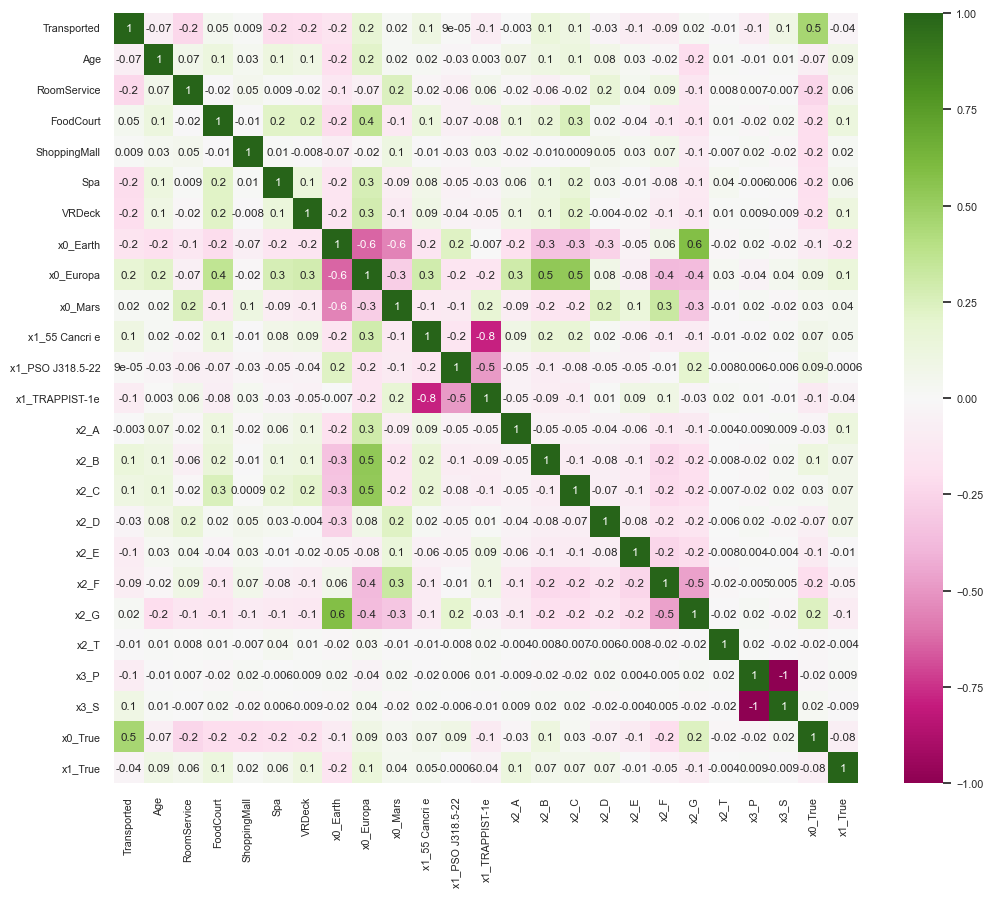

In [47]:
cor = pd.concat((y_train, X_train_enc), axis=1).iloc[:, :].corr()
plt.figure(figsize=(12, 10))
sns.set(font_scale=0.7)
sns.heatmap(cor, annot=True, fmt='.1g', cmap=plt.cm.PiYG)

The highest correlations that stand out are for VIP True being highly impactful on being transported and the correlation between home planets and deck level.

I wanted to look at some more feature importances so I made a SHAP plot.

In [48]:
import shap

# Create a shap explainer object 
pipe_lgbm.named_steps["lgbmclassifier"].fit(X_train_enc, y_train)
lgbm_explainer = shap.TreeExplainer(pipe_lgbm.named_steps["lgbmclassifier"])
train_lgbm_shap_values = lgbm_explainer.shap_values(X_train_enc)

In [49]:
shap.initjs()

This SHAP plot looks at the 14 most impactful features and shows how they impact the model.

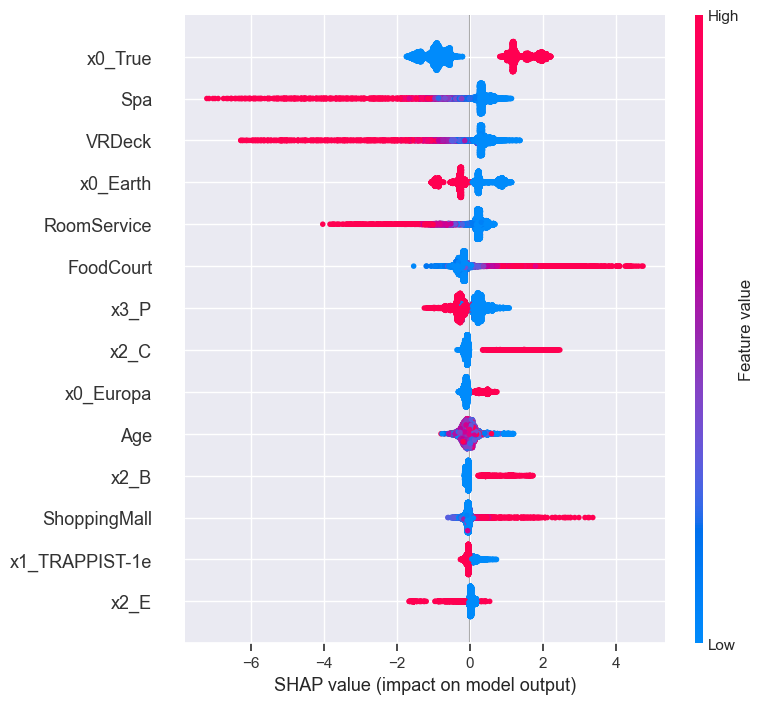

In [50]:
shap.summary_plot(train_lgbm_shap_values[1], feature_names=new_columns, features=X_train_enc, max_display=14)

It is interesting to see how features like Spa, VR deck, Room service, and Shopping Mall (which are all based on how much you spend at those locations) impacted the model more than other features.

## Results

Here is a list of the final models and their training and testing accuracies.

In [51]:
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Decision tree,0.065 (+/- 0.016),0.012 (+/- 0.003),0.737 (+/- 0.009),0.949 (+/- 0.003)
Decision tree - tuned,0.081 (+/- 0.012),0.021 (+/- 0.005),0.772 (+/- 0.014),0.792 (+/- 0.003)
Random forests,0.334 (+/- 0.027),0.038 (+/- 0.004),0.784 (+/- 0.010),0.949 (+/- 0.003)
Random forests - tuned,0.428 (+/- 0.010),0.050 (+/- 0.001),0.784 (+/- 0.010),0.949 (+/- 0.003)
Random forest,0.475 (+/- 0.050),0.056 (+/- 0.005),0.784 (+/- 0.010),0.949 (+/- 0.003)
Logistic regression,0.183 (+/- 0.026),0.023 (+/- 0.003),0.787 (+/- 0.010),0.793 (+/- 0.005)
XGBoost,0.612 (+/- 0.049),0.025 (+/- 0.001),0.791 (+/- 0.015),0.900 (+/- 0.007)
LightGBM,0.691 (+/- 0.469),0.028 (+/- 0.003),0.797 (+/- 0.018),0.866 (+/- 0.003)
sklearn_histGB,0.883 (+/- 0.043),0.028 (+/- 0.002),0.801 (+/- 0.016),0.862 (+/- 0.004)
sklearn_GB,1.166 (+/- 0.028),0.021 (+/- 0.001),0.798 (+/- 0.013),0.816 (+/- 0.003)


I was able to use several machine learning models to predict the transportation of passengers by the anomaly. The *Histogram-based Gradient Boosting Classification Tree* from SKLearn was my best performing model. It gave me a train score of $.862$ and a test score of $.801$. On the final Kaggle submission, it gave a score of $0.79892$.


Even with hyperparameter optimization, the decision tree and random forest models could not compete with the SKLearn hist-GB model. The ensemble models (voting and stacking) also relied heavily on that model as well.


The accuracy score could be increased by either tuning the SKLearn hist-GB model better or finding other models that would work better together in the ensemble models.


Since a lot of the model performed similar (around $.77$ to $.80$) it may also be impactful to do some more indepth feature engineering. If I had more time, it would have been benificial to figure out which features could be combined or altered to produce better results.